In [1]:
import datetime
from dateutil.tz import tzutc
from plotnine import *
from edx_stats import grouped_confidence_intervals
from edx_plot import geom_confidence, theme_confidence

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

Boilerplate Connection Setup
---

In [3]:
%load_ext edx_jupyter

In [11]:
%reload_ext edx_jupyter

In [12]:
%vertica SELECT 'Connected'

,?column?
0,Connected


In [23]:
alpha = 0.1
effect_size = 0.2
power = 0.8
experiment_id = 8449172827

In [24]:
experiment_start = datetime.datetime(2017, 6, 26, 0, tzinfo=tzutc())

In [25]:
%%vertica

SET TIME ZONE 'UTC'

,variation_name,user_id,pacing_type,weeks_since_experiment_start,engagement_events


In [26]:
%%vertica (experiment_id = experiment_id)

DROP TABLE IF EXISTS exp5_experiment_views;
CREATE LOCAL TEMPORARY TABLE exp5_experiment_views
ON COMMIT PRESERVE ROWS AS
SELECT
    received_at::TIMESTAMPTZ,
    timestamp::TIMESTAMPTZ,
    anonymous_id,
    user_id AS raw_user_id,
    CASE
        WHEN REGEXP_LIKE(user_id, '^\d+$') THEN user_id::INT
        ELSE NULL
    END AS user_id,
    experimentid::INT AS experiment_id,
    experimentname AS experiment_name,
    variationid::INT AS variation_id,
    variationname AS variation_name,
    CASE 
        WHEN STRPOS(path, '%') = 0 THEN REGEXP_SUBSTR(path, '/courses/([^/+]+(/|\+)[^/+]+(/|\+)[^/?]+)/', 1, 1, '', 1)
        ELSE URI_PERCENT_DECODE(REGEXP_SUBSTR(path, '/courses/([^/+]+(/|\+)[^/+]+(/|\+)[^/?]+)/', 1, 1, '', 1))
    END AS course_id,
    path,
    url
FROM
    experimental_events_run14.event_records event
WHERE
        event_type = 'Experiment Viewed'
    AND experimentid = :experiment_id

,variation_name,user_id,pacing_type,weeks_since_experiment_start,engagement_events


In [27]:
%%vertica (start_time = experiment_start, experiment_id = experiment_id) -> df_raw

SELECT
    viewed.variation_name,
    viewed.user_id,
    engaged.pacing_type,
    engaged.weeks_since_experiment_start,
    engaged.engagement_events
FROM
(
    SELECT
        user_id,
        MIN(variation_name) AS variation_name,
        MIN(received_at) AS exposure_time
    FROM
        exp5_experiment_views
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1
    HAVING COUNT(DISTINCT variation_name) = 1
) AS viewed
JOIN
(
    SELECT
        user_id,
        course.pacing_type,
        FLOOR(DATEDIFF('day', :start_time, date) / 7) AS weeks_since_experiment_start,
        SUM(cnt_engaged_activity) AS engagement_events
    FROM
        business_intelligence.activity_engagement_user_daily AS engage
    JOIN
        production.d_course AS course
    ON
        engage.course_id = course.course_id
    WHERE
        date > :start_time
    GROUP BY 1, 2, 3
) AS engaged
ON engaged.user_id = viewed.user_id


In [28]:
df = df_raw.copy()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279545 entries, 0 to 279544
Data columns (total 5 columns):
variation_name                  279545 non-null object
user_id                         279545 non-null int64
pacing_type                     279302 non-null object
weeks_since_experiment_start    279545 non-null object
engagement_events               279545 non-null int64
dtypes: int64(2), object(3)
memory usage: 10.7+ MB


In [30]:
counts = df.groupby('variation_name').count()
counts['num_users'] = counts['user_id']
counts[['num_users']]

,num_users
variation_name,
Fixed Footer,69815
Original,69968
Polite Footer,69864
The Sock,69898


In [31]:
totals = df.groupby(
    ['weeks_since_experiment_start', 'pacing_type', 'variation_name']
).sum().merge(
    counts[['num_users']],
    left_index=True,
    right_index=True,
)
del totals['user_id']

In [32]:
totals

engagement_events  \
weeks_since_experiment_start pacing_type      variation_name                      
0                            instructor_paced Fixed Footer               305025   
                                              Original                   317019   
                                              Polite Footer              379956   
                                              The Sock                   328262   
                             self_paced       Fixed Footer               499541   
                                              Original                   517333   
                                              Polite Footer              495298   
                                              The Sock                   488117   
1                            instructor_paced Fixed Footer               354353   
                                              Original                   358953   
                                              Polite Footer              362709   
                                              The Sock                   344076   
                             self_paced       Fixed Footer               573260   
                                              Original                   571059   
                                              Polite Footer              583213   
                                              The Sock                   568876   

                                                              num_users  
weeks_since_experiment_start pacing_type      variation_name             
0                            instructor_paced Fixed Footer        69815  
                                              Original            69968  
                                              Polite Footer       69864  
                                              The Sock            69898  
                             self_paced       Fixed Footer        69815  
                                              Original            69968  
                                              Polite Footer       69864  
                                              The Sock            69898  
1                            instructor_paced Fixed Footer        69815  
                                              Original            69968  
                                              Polite Footer       69864  
                                              The Sock            69898  
                             self_paced       Fixed Footer        69815  
                                              Original            69968  
                                              Polite Footer       69864  
                                              The Sock            69898

In [33]:
conf_intervals = grouped_confidence_intervals(
    df,
    variant_col='variation_name',
    value_col='engagement_events',
    ctrl_name='Original',
    group_cols=['pacing_type', 'weeks_since_experiment_start'],
)

/app/lib/edx_stats.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


In [34]:
conf_intervals

bootstrap  \
pacing_type      weeks_since_experiment_start variation_name                                                      
instructor_paced 0                            Fixed Footer    -3.615498378459243    (-6.763305238191803, -0....   
                                              Original           0.0    (-3.196043174523674, 3.159427924411583)   
                                              Polite Footer   20.017779126521106    (3.691086424722151, 35.8...   
                                              The Sock        3.622465573746408    (0.23637984402034018, 6.9...   
                 1                            Fixed Footer    -1.9755865744478298    (-5.573068328820263, 1....   
                                              Original           0.0    (-3.542278326331691, 3.478258864737647)   
                                              Polite Footer   -0.04509486397623289    (-3.4732284021636946, ...   
                                              The Sock        -3.890382258564804    (-7.217990893667947, -0....   
self_paced       0                            Fixed Footer    -2.4515022709305456    (-7.059788456970741, 1....   
                                              Original          0.0    (-6.042493796798772, 5.6247943313774895)   
                                              Polite Footer   -2.7693566486969576    (-7.3470720580036994, 1...   
                                              The Sock        -4.82266605977059    (-9.319677535218176, -0.7...   
                 1                            Fixed Footer    0.3102173388325895    (-2.1585154715807544, 2....   
                                              Original         0.0    (-2.4695474913556903, 2.4333416852858294)   
                                              Polite Footer   1.6190682806691932    (-1.6313284711937523, 4....   
                                              The Sock        -1.0460780404678116    (-3.452336925258547, 1....   

                                                              percent_change  \
pacing_type      weeks_since_experiment_start variation_name                   
instructor_paced 0                            Fixed Footer         -3.615498   
                                              Original              0.000000   
                                              Polite Footer        20.017779   
                                              The Sock              3.622466   
                 1                            Fixed Footer         -1.975587   
                                              Original              0.000000   
                                              Polite Footer        -0.045095   
                                              The Sock             -3.890382   
self_paced       0                            Fixed Footer         -2.451502   
                                              Original              0.000000   
                                              Polite Footer        -2.769357   
                                              The Sock             -4.822666   
                 1                            Fixed Footer          0.310217   
                                              Original              0.000000   
                                              Polite Footer         1.619068   
                                              The Sock             -1.046078   

                                                              lower_bound  \
pacing_type      weeks_since_experiment_start variation_name                
instructor_paced 0                            Fixed Footer      -6.763305   
                                              Original          -3.196043   
                                              Polite Footer      3.691086   
                                              The Sock           0.236380   
                 1                            Fixed Footer      -5.573068   
                                              Origi

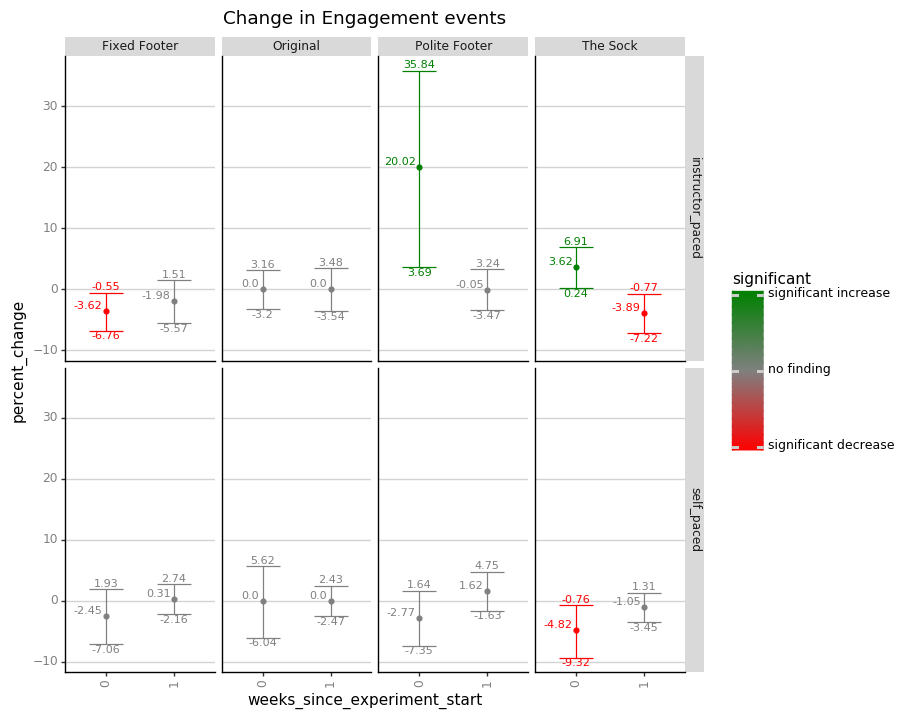

<ggplot: (-9223363247903023693)>

In [35]:
(
    ggplot(conf_intervals.reset_index(), aes(
        x='weeks_since_experiment_start',
        y='percent_change',
        ymin='lower_bound',
        ymax='upper_bound',
        color='significant',
        label_size=0.5,
    ))
    + geom_confidence()
    + facet_grid("pacing_type ~ variation_name")
    + theme_confidence()
    + ggtitle("Change in Engagement events")
)
